In [1]:
from fastai.vision.all import * 
import joblib 
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('/kaggle/input/hms-harmful-brain-activity-classification')
Path.BASE_PATH = Path
path.ls()

(#8) [Path('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs'),Path('/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv'),Path('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms'),Path('/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'),Path('/kaggle/input/hms-harmful-brain-activity-classification/example_figures'),Path('/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'),Path('/kaggle/input/hms-harmful-brain-activity-classification/train.csv'),Path('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')]

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [4]:
df.isnull().sum()

eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
expert_consensus                    0
seizure_vote                        0
lpd_vote                            0
gpd_vote                            0
lrda_vote                           0
grda_vote                           0
other_vote                          0
dtype: int64

In [5]:
df = pd.read_csv(f'{path}/train.csv')
df['eeg_path'] = f'{path}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{path}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{path}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
display(df.head(2))


test_df = pd.read_csv(f'{path}/test.csv')
test_df['eeg_path'] = f'{path}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{path}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{path}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1628180742.parquet,/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.parquet,/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.npy,Seizure
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1628180742.parquet,/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.parquet,/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/353733.npy,Seizure


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/3911565283.parquet,/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/853520.parquet,/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/853520.npy


In [6]:
SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [7]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{path}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)
    
# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

100%|██████████| 1/1 [00:00<00:00, 615.90it/s]


In [8]:
image_path = Path('/tmp/dataset/hms-hbac/')

In [9]:
df['spec2_path'] = f'{image_path}/train_spectrograms/' + df['spectrogram_id'].astype(str)+'.npy'

In [10]:
sample_df = df.groupby('spectrogram_id').head(1).reset_index(drop=True)
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2)
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Num Train: 85440 | Num Valid: 21360


In [11]:
def ArrayToPILImage(x):
    x = np.load(x)
    return PILImage.create(Image.fromarray((x * 255).astype(np.uint8)))

def ImageBlock(cls=PILImage):
    return TransformBlock(type_tfms=ArrayToPILImage, batch_tfms=IntToFloatTensor)

# **Create a datablock**

In [12]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(17),  
    get_y=ColReader(18),
    splitter=RandomSplitter(),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [13]:
ds = dblock.datasets(train_df)

# **Create a dataloader:=**

In [14]:
dls = dblock.dataloaders(train_df)

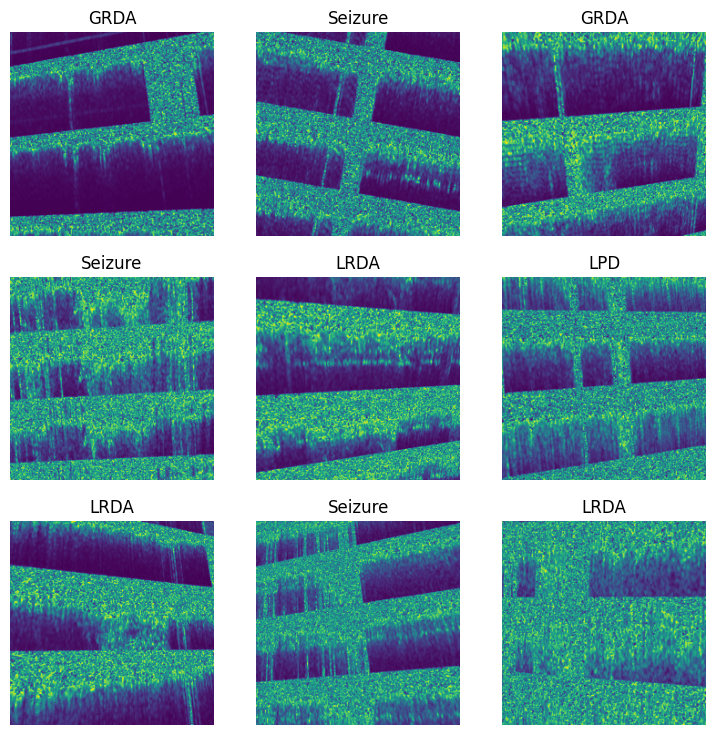

In [15]:
# show bactch : 
dls.show_batch()

In [16]:
#learn = vision_learner(dls, resnet50, metrics=accuracy)
#learn.fine_tune(5)

# **Train with densenet 169:=**

In [17]:
from fastai.callback.fp16 import * 

In [18]:
learn_2 = vision_learner(dls, 'densenet169', metrics=accuracy).to_fp16()
learn_2.fine_tune(10)

model.safetensors:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.385523,1.233154,0.534352,06:38


epoch,train_loss,valid_loss,accuracy,time
0,1.167411,1.052712,0.622015,08:31
1,1.054117,0.956685,0.638694,08:32
2,0.960433,0.876638,0.672343,08:30
3,0.868255,0.771964,0.720915,08:30
4,0.797388,0.692525,0.746957,08:28
5,0.721734,0.635292,0.775925,08:33
6,0.680954,0.595348,0.786458,08:31
7,0.643502,0.576483,0.791433,08:32
8,0.619545,0.563583,0.800562,08:32
9,0.607859,0.561915,0.799157,08:36


# **Find the best LR:=**

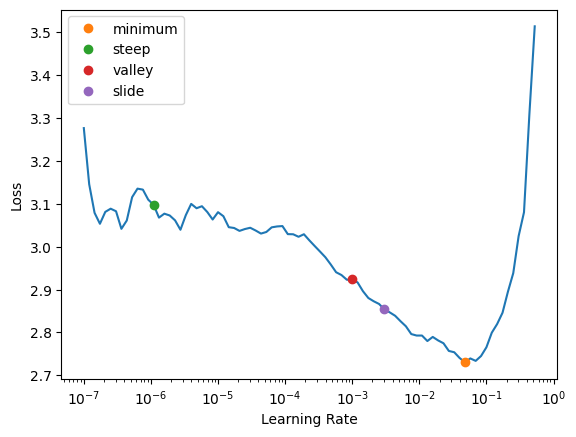

In [19]:
learn = vision_learner(dls, 'densenet169', metrics=accuracy)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# **Train by using more layers densenet201:=**

In [20]:
learn_dens = vision_learner(dls, 'densenet201', metrics=accuracy)
learn_dens.fine_tune(10)

model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.341766,1.220136,0.533474,09:16


epoch,train_loss,valid_loss,accuracy,time
0,1.124263,1.027700,0.623478,11:42
1,1.025017,0.927643,0.657303,11:45
2,0.925974,0.822571,0.697507,11:43
3,0.811201,0.716289,0.745611,11:44
4,0.741971,0.657819,0.763928,11:43
5,0.673623,0.601940,0.785112,11:44
6,0.617699,0.557326,0.803020,11:43
7,0.576612,0.542962,0.807818,11:43
8,0.551431,0.526808,0.812559,11:43
9,0.565212,0.525453,0.814431,11:43


# Save the model : 

In [21]:
learn_dens.save('/kaggle/working/HMS_TS_densenet201', with_opt=False)

Path('/kaggle/working/HMS_TS_densenet201.pth')